In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import time

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
#List off school-related features and list possible values for each.
school_features = [
                   'SCHOOL_YEAR',
                   'DIV_NAME',
                   'SCH_NAME',
    
                   'per_capita_income',
                   'median_household_income',
                   'median_family_income',
                   'StudentNumber',
                   'STRatio',
                   'MathProficiency',
                   'ReadingProficiency',
                  ]

#List off student-related features and list possible values for each.
student_features= [
                   'FEDERAL_RACE_CODE',
                   'GENDER',
                   'DISABILITY_FLAG',
                   'LEP_FLAG',
                   'DISADVANTAGED_FLAG',
                  ]

#List off statistic features.
stat_features   = [
                   'COHORT_CNT',
                   'DIPLOMA_RATE',
                   'DROPOUT_RATE',
                  ]

In [3]:
df = pd.read_csv('data/ALL_YEARS_ADDED_FEATURES.csv')
keep = (df['DIPLOMA_RATE'] >= 0) & (df['DIPLOMA_RATE'] <= 100)
df = df[keep]

In [4]:
df.describe()

,FEDERAL_RACE_CODE,COHORT_CNT,DIPLOMA_RATE,DROPOUT_RATE,per_capita_income,median_household_income,median_family_income,StudentNumber,STRatio,MathProficiency,ReadingProficiency
count,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000,72069.000000
mean,7.826056,14.848812,86.095190,9.411189,33464.896488,72220.012217,84360.979429,1573.095325,14.837836,75.556800,87.698026
std,18.848700,24.982341,22.599871,19.597367,10290.340031,25602.314907,27862.199996,749.408463,2.157568,11.480725,6.873563
min,0.000000,1.000000,0.000000,0.000000,16278.000000,22333.000000,34077.000000,20.000000,6.000000,15.000000,49.000000
25%,3.000000,2.000000,80.000000,0.000000,24249.000000,49224.000000,59613.000000,1028.000000,13.000000,69.000000,83.000000
50%,4.000000,6.000000,99.029126,0.000000,31711.000000,70299.000000,78718.000000,1672.000000,15.000000,77.000000,89.000000
75%,5.000000,15.000000,100.000000,10.000000,45356.000000,101658.000000,117278.000000,2135.000000,16.000000,84.000000,92.000000
max,99.000000,245.000000,100.000000,100.000000,57724.000000,115574.000000,142035.000000,3783.000000,21.000000,99.000000,99.000000


In [5]:
df

,SCHOOL_YEAR,DIV_NAME,SCH_NAME,GENDER,FEDERAL_RACE_CODE,DISABILITY_FLAG,DISADVANTAGED_FLAG,LEP_FLAG,COHORT_CNT,DIPLOMA_RATE,DROPOUT_RATE,per_capita_income,median_household_income,median_family_income,StudentNumber,STRatio,MathProficiency,ReadingProficiency
0,2007-2008,Accomack County,Arcadia High,F,3.0,Y,N,N,3,66.666667,33.333333,22766.0,41372.0,49727.0,603.0,14.0,74.0,77.0
1,2007-2008,Accomack County,Arcadia High,F,3.0,Y,Y,N,7,100.000000,0.000000,22766.0,41372.0,49727.0,603.0,14.0,74.0,77.0
2,2007-2008,Accomack County,Arcadia High,F,5.0,N,N,N,33,75.757576,9.090909,22766.0,41372.0,49727.0,603.0,14.0,74.0,77.0
3,2007-2008,Accomack County,Arcadia High,F,5.0,N,Y,N,13,46.153846,46.153846,22766.0,41372.0,49727.0,603.0,14.0,74.0,77.0
4,2007-2008,Accomack County,Arcadia High,F,5.0,Y,N,N,3,66.666667,33.333333,22766.0,41372.0,49727.0,603.0,14.0,74.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72066,2018-2019,York County,Grafton High,M,5.0,Y,Y,N,3,100.000000,0.000000,35823.0,81055.0,92597.0,1193.0,15.0,86.0,95.0
72067,2018-2019,York County,Tabb High,M,5.0,Y,Y,N,1,100.000000,0.000000,35823.0,81055.0,92597.0,1183.0,15.0,87.0,92.0
72068,2018-2019,York County,York High,M,5.0,Y,Y,N,1,100.000000,0.000000,35823.0,81055.0,92597.0,1075.0,14.0,88.0,92.0
72069,2018-2019,York County,Tabb High,M,5.0,N,Y,Y,1,100.000000,0.000000,35823.0,81055.0,92597.0,1183.0,15.0,87.0,92.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f589d677350>,
      dtype=object)

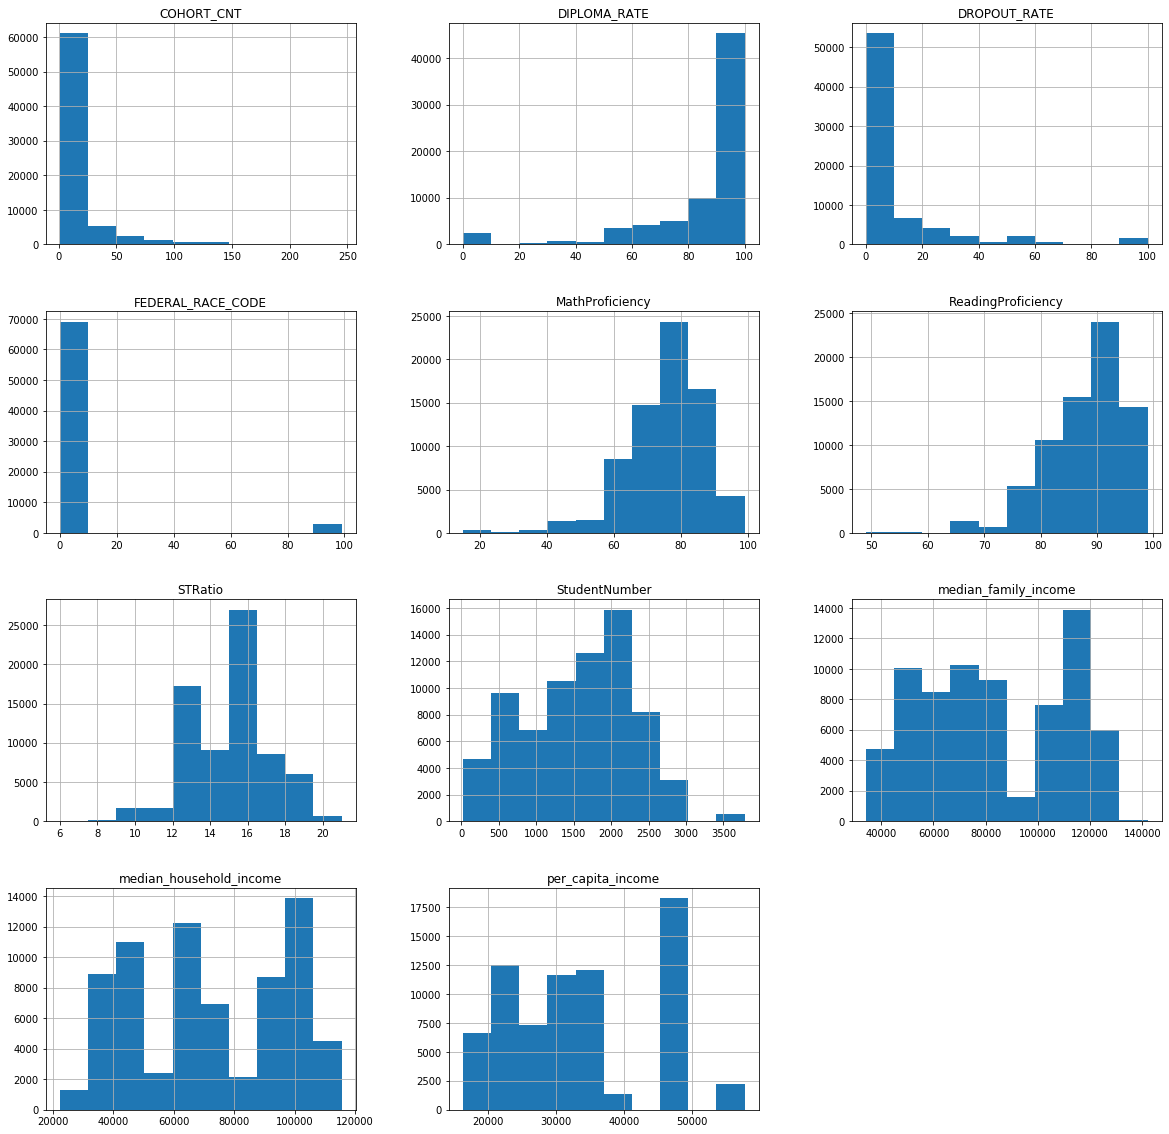

In [7]:
df.hist(figsize=(20,20))

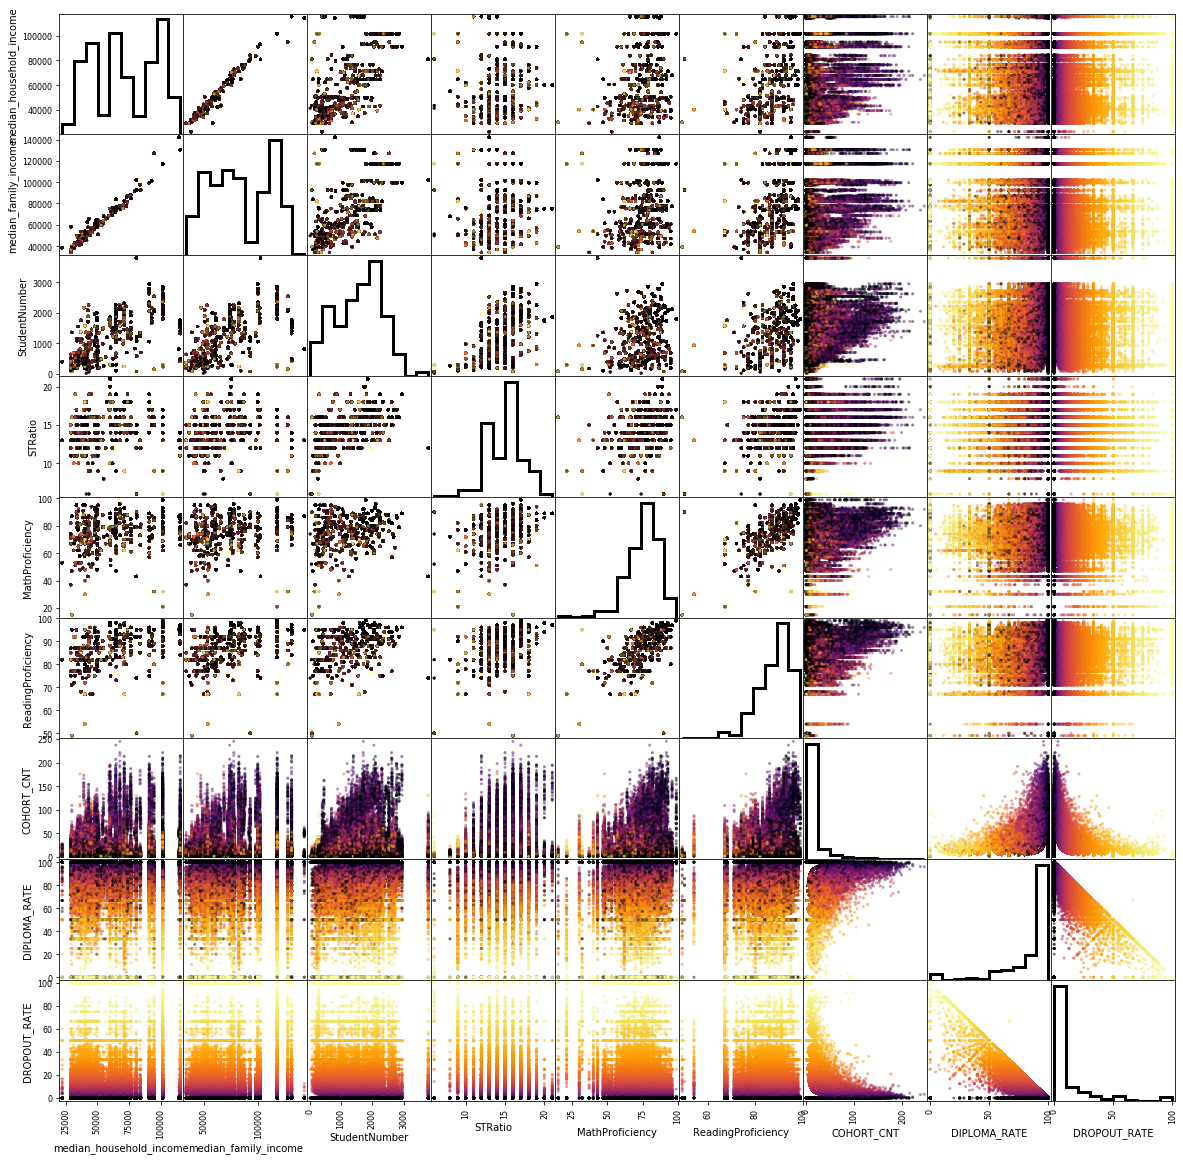

In [10]:
scatter_matrix(df[school_features[4:]+stat_features],
               figsize=(20,20),diagonal='hist',hist_kwds={'histtype':'step',
                                                          'lw':3,
                                                          'color':'black'},
               c=np.log10(df['DROPOUT_RATE']+1),cmap='inferno');

## Wacky attempt at "normalizing" the small-number statistics

(0, 100)

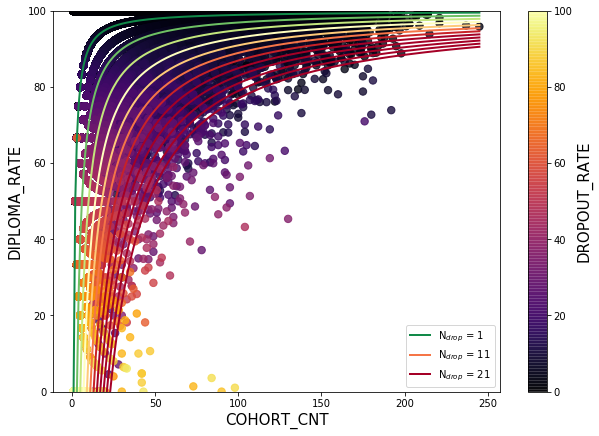

In [6]:
fig,ax=plt.subplots(figsize=(10,7))
sort = np.argsort(df['DROPOUT_RATE'])
scat = ax.scatter(df['COHORT_CNT'].iloc[sort],df['DIPLOMA_RATE'].iloc[sort],c=df['DROPOUT_RATE'].iloc[sort],
           cmap='inferno',alpha=0.8,s=55)
cbar = fig.colorbar(scat)
ax.set_xlabel('COHORT_CNT',fontsize=15)
ax.set_ylabel('DIPLOMA_RATE',fontsize=15)
cbar.ax.set_ylabel('DROPOUT_RATE',fontsize=15)

COHORT_CNT = np.arange(1,np.max(df['COHORT_CNT'])+1)
cm = plt.get_cmap('RdYlGn_r')
for ndrop in range(1,25,2):
    c = cm(ndrop/14)
    if (ndrop-1)%5==0:
        ax.plot(COHORT_CNT, 100*(COHORT_CNT-ndrop)/COHORT_CNT,color=c,lw=2,label='N$_{drop}$ = %d'%(ndrop))
    else:
        ax.plot(COHORT_CNT, 100*(COHORT_CNT-ndrop)/COHORT_CNT,color=c,lw=2)
#ax.plot(COHORT_CNT, 100*(COHORT_CNT-10)/COHORT_CNT,color='cornflowerblue')
ax.legend(loc=4)
ax.set_ylim(0,100)

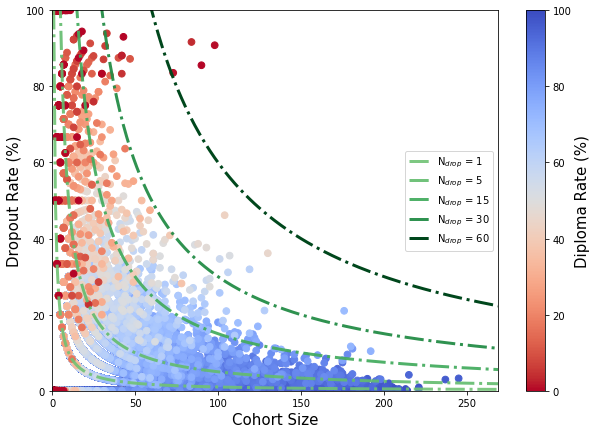

In [38]:
fig,ax=plt.subplots(figsize=(10,7))
sort = np.argsort(-df['DIPLOMA_RATE'])
scat = ax.scatter(df['COHORT_CNT'].iloc[sort],df['DROPOUT_RATE'].iloc[sort],c=df['DIPLOMA_RATE'].iloc[sort],
           cmap='coolwarm_r',alpha=1.0,s=45)
cbar = fig.colorbar(scat)
ax.set_xlabel('Cohort Size',fontsize=15)
ax.set_ylabel('Dropout Rate (%)',fontsize=15)
cbar.ax.set_ylabel('Diploma Rate (%)',fontsize=15)

COHORT_CNT = np.arange(1,1.1*np.max(df['COHORT_CNT']))
cm = plt.get_cmap('Greens')#RdYlGn_r')
ls ='-.'
for ndrop in [1,5,15,30,60]:
    c = cm(0.5+0.5*ndrop/61)
    alpha=0.9+0.1*ndrop/61
    if True:#(ndrop-1)%5==0:
        ax.plot(COHORT_CNT, 100*(ndrop)/COHORT_CNT,color=c,lw=3,alpha=alpha,ls=ls,label='N$_{drop}$ = %d'%(ndrop))
    else:
        ax.plot(COHORT_CNT, 100*(ndrop)/COHORT_CNT,color=c,lw=3,alpha=alpha,ls=ls)
#ax.plot(COHORT_CNT, 100*(COHORT_CNT-10)/COHORT_CNT,color='cornflowerblue')
ax.legend(loc="center right")
ax.set_ylim(0,100)
ax.set_xlim(0,max(COHORT_CNT))
fig.savefig('figures/small_number_stats.pdf')

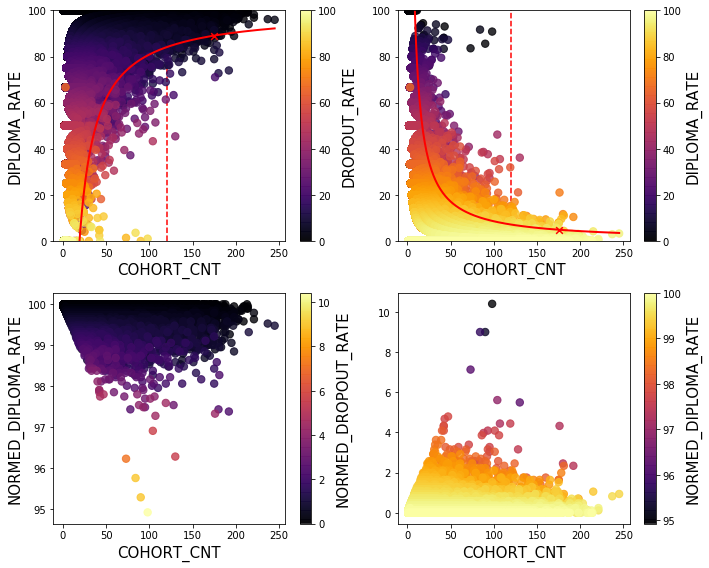

In [120]:
def normalize_rates(df,count_thresh=150,p=50):
    use = df['COHORT_CNT']>count_thresh
    mean_diploma_rate = np.percentile(df['DIPLOMA_RATE'][use],100-p)
    mean_dropout_rate = np.percentile(df['DROPOUT_RATE'][use],p)
    mean_cohort_cnt = np.percentile(df['COHORT_CNT'][use],p)
    
    fig,axs = plt.subplots(2,2,figsize=(10,8))
    axs = axs.flatten()
    
    ### Diploma Rate 'Fit' ###
    ax = plot3(df,ax=axs[0])
    ax.scatter(mean_cohort_cnt,mean_diploma_rate,s=45,marker='x',color='red')
    ax.axvline(count_thresh,ls='--',color='red',zorder=-1)
    
    COHORT_CNT = np.arange(1,np.max(df['COHORT_CNT'])+1)
    ndown = mean_cohort_cnt*(100-mean_diploma_rate)/100.
    ax.plot(COHORT_CNT, 100*(COHORT_CNT-ndown)/COHORT_CNT,color='red',lw=2)
    ax.set_ylim(0,100)
    
    ### Dropout Rate 'Fit' ###
    ax = plot3(df,y='DROPOUT_RATE',c='DIPLOMA_RATE',ax=axs[1])
    ax.scatter(mean_cohort_cnt,mean_dropout_rate,s=45,marker='x',color='red')
    ax.axvline(count_thresh,ls='--',color='red',zorder=-1)
    
    COHORT_CNT = np.arange(1,np.max(df['COHORT_CNT'])+1)
    nup = mean_cohort_cnt*(mean_dropout_rate)/100.
    ax.plot(COHORT_CNT, 100*(nup)/COHORT_CNT,color='red',lw=2)
    ax.set_ylim(0,100)
    
    ### Normalize ###
    dropout_fit = (100*(nup)/df['COHORT_CNT'])
    df['NORMED_DROPOUT_RATE'] = df['DROPOUT_RATE'] / (100*(nup)/df['COHORT_CNT'])
    df['NORMED_DIPLOMA_RATE'] = 100 - (100-df['DIPLOMA_RATE']) / (100-(100*(df['COHORT_CNT']-ndown)/df['COHORT_CNT']))
    ax = plot3(df,y='NORMED_DIPLOMA_RATE',c='NORMED_DROPOUT_RATE',ax=axs[2])
    ax = plot3(df,y='NORMED_DROPOUT_RATE',c='NORMED_DIPLOMA_RATE',ax=axs[3])
    
    axs[1].set_ylabel('')
    axs[3].set_ylabel('')
    plt.tight_layout()
    fig.savefig('test_normalize.png')
    
def plot3(df,x='COHORT_CNT',y='DIPLOMA_RATE',c='DROPOUT_RATE',ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(10,7))
    sort = np.argsort(df[c])
    scat = ax.scatter(df[x].iloc[sort],df[y].iloc[sort],c=df[c].iloc[sort],
               cmap='inferno',alpha=0.8,s=55)
    cbar = ax.figure.colorbar(scat,ax=ax)
    ax.set_xlabel(x,fontsize=15)
    ax.set_ylabel(y,fontsize=15)
    cbar.ax.set_ylabel(c,fontsize=15)
    return ax

normalize_rates(df,p=90,count_thresh=120)

### Function to expand a dataframe into student-by-student rows.

In [11]:
def expand_rates(df,nrows='all'):
    new_df = None
    t = time.time()
    if nrows == 'all':
        nrows = df[0].shape
    for i in range(nrows):#df.shape[0]):
        #Count up students dropping out, graduating, or otherwise
        N_cohort = df.iloc[i]['COHORT_CNT']
        N_drop   = np.round((df.iloc[i]['DROPOUT_RATE']/100)*N_cohort).astype(int)
        N_grad   = np.round((df.iloc[i]['DIPLOMA_RATE']/100)*N_cohort).astype(int)
        N_else   = N_cohort - N_drop - N_grad
        
        try:
            #Sanity check
            assert N_else >= 0
        except AssertionError:
            raise ValueError("Something has gone terribly wrong. Inconsistent diploma/dropout rates.")
        
        #Make a template row without dropout/diploma rates and with true/false instead.
        row_orig = df.iloc[i:(i+1)].copy()
        row_orig.drop(['DROPOUT_RATE','DIPLOMA_RATE'],axis=1)
        row_orig['DROP'] = 0
        row_orig['GRAD'] = 0
        
        #Make template dropout row and template graduate row.
        row_drop = row_orig.copy()
        row_drop['DROP'] = 1
        row_grad = row_orig.copy()
        row_grad['GRAD'] = 1
        
        #Make mini-table with the number of dropouts, grads, and otherwise.
        row_expanded = pd.concat( N_drop*[row_drop] + N_grad*[row_grad] + N_else*[row_orig] )
        
        #Append mini-table to the full, expanded table.
        new_df = pd.concat([new_df,row_expanded])
        
    print((time.time()-t),'seconds')
    return new_df
expanded = expand_rates(df,nrows=100)
print(expanded.shape)



1.8178741931915283 seconds
(1569, 20)


## Test different regression models
#### Prepare the data

In [58]:
X = df.drop(['SCHOOL_YEAR','DIV_NAME','SCH_NAME','DROPOUT_RATE','DIPLOMA_RATE'],axis=1)
y = df['DROPOUT_RATE']

X_train_raw,X_test_raw,y_train,y_test = train_test_split(X,y)
w_train = X_train_raw['COHORT_CNT'].to_numpy() #later, weight by cohort size
w_test  = X_test_raw['COHORT_CNT'].to_numpy()

#### Make pipeline for the data

In [17]:
num_feats = [feat for feat in school_features if not feat in ['SCHOOL_YEAR','DIV_NAME','SCH_NAME']]
ord_cat_feats = ['FEDERAL_RACE_CODE']
ohe_cat_feats = [feat for feat in student_features if not feat in ord_cat_feats]

pipeline = ColumnTransformer([
    ('num',StandardScaler(),num_feats),
    ('ord',OrdinalEncoder(),ord_cat_feats),
    ('ohe',OneHotEncoder(),ohe_cat_feats),
])

X_train = pipeline.fit_transform(X_train_raw)
X_test = pipeline.fit_transform(X_test_raw)

#### Function to make sorted scatterplot with colors from colormap

In [43]:
def color_scatter(x,y,colorby=None,ax=None,reverse=False,**kwargs):
    #Define default plotting arguments
    plot_kwargs = {
        'color':'orange',
        'cmap':'cividis_r',
        'alpha':0.3,
    }
    #Update defaults with user-provided arguments
    plot_kwargs.update(kwargs)
    
    #Make axes if none were given.
    if ax is None:
        fig,ax=plt.subplots()
    
    #Determine sort and color based on inputs provided.
    if colorby is None:
        sort = np.arange(y_test.shape[0]).astype(int)
        color = plot_kwargs['color']
    else:
        r = 1.
        if reverse: r = -1
        sort = np.argsort(r*colorby)
        color = colorby[sort]
    del plot_kwargs['color']
    
    #Make scatter plot!
    scat = ax.scatter(x[sort],y[sort],c=color,**plot_kwargs)
    
    if len(color) == len(x):
        cbar = ax.figure.colorbar(scat,ax=ax)
    else:
        cbar = None
    
    return ax,cbar

In [54]:
def train_and_plot(regressor,X_train=X_train,train_weights=None,y_train=y_train,X_test=X_test,y_test=y_test,
                   plot_resid=True,plot_predvsact=False,colorby=None,**hyperparams):
    #Make sure training and testing data are in good format.
    good_dat = lambda Xory: np.array(Xory.copy())
    X_train = good_dat(X_train)
    y_train = good_dat(y_train)
    X_test  = good_dat(X_test)
    y_test  = good_dat(y_test)
    
    if train_weights is None:
        train_weights = np.ones_like(y_train)
    
    reg = regressor(**hyperparams)
    reg.fit(X_train,y_train,sample_weight=train_weights)
    print("Training MSE: %.2f, Testing MSE: %.2f"%(mean_squared_error(reg.predict(X_train),y_train),
                                                   mean_squared_error(reg.predict(X_test),y_test)))
    if plot_resid:
        #Plot (y_pred - y_test) as a function of y_test
        test_resid = reg.predict(X_test) - y_test
        ax,cbar = color_scatter(y_test,test_resid,colorby=colorby)
        ax.set_xlim(min(y_test),max(y_test))
        ax.set_xlabel('Actual y')
        ax.set_ylabel('Predicted - Actual y')
        cbar.ax.set_ylabel('COHORT_CNT')
    if plot_predvsact:
        #Plot y_pred as a function of y_test
        ax = color_scatter(y_test,reg.predict(X_test),colorby=colorby)
        ymi,yma = min(y_test),max(y_test)
        ax.set_xlim(ymi,yma)
        ax.plot([ymi,ymi],[yma,yma],color='black',ls='--',lw=3)
        ax.set_xlabel('Actual y')
        ax.set_ylabel('Predicted')
        cbar.ax.set_ylabel('COHORT_CNT')

#### Test LinearRegression

Training MSE: 356.80, Testing MSE: 374.94
Training MSE: 371.78, Testing MSE: 389.51


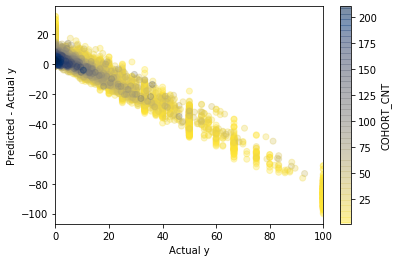

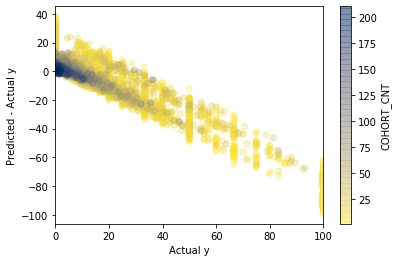

In [55]:
train_and_plot(LinearRegression,colorby=w_test)
train_and_plot(LinearRegression,colorby=w_test,train_weights=w_train)

##### Systematically underestimating high dropout rates (mostly from small cohorts)
##### Adding weights makes the model perform worse?!

#### Testing RandomForestRegressor

Training MSE: 231.45, Testing MSE: 465.85
Training MSE: 319.54, Testing MSE: 388.94


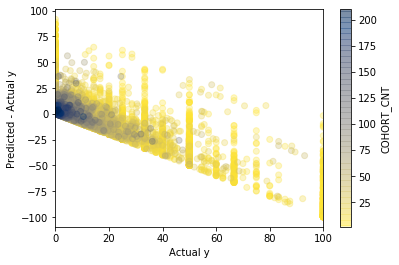

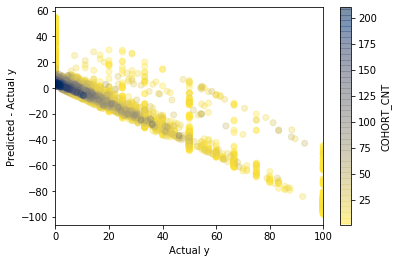

In [57]:
train_and_plot(RandomForestRegressor,colorby=w_test,n_estimators=100)
train_and_plot(RandomForestRegressor,colorby=w_test,n_estimators=100,
               min_samples_leaf=8,min_samples_split=16,max_depth=6)

#### With no regularization, RFR super overfits (makes sense). With some regularization, it still overfits a bit.
#### Later I'll try more rigorous search through hyperparameters.